In [1]:
import os
import cv2
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.activations import relu, softmax
from keras.layers import Lambda, Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec
%matplotlib inline

Using TensorFlow backend.


### Step 1 Load data
***
1.1 Load sample data.
  
1.2 Apply left and right camera steering correction (+-0.25) and store image file name to numpy array.
  
1.3 Train/Validation split
  
1.4 Random select data for training and validation based on keep probability.
  
1.5 Generate balanced data (since we have more data which steering is equal to 0). 
  
1.6 Data distribution visualization
***

In [2]:
datadir = './data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv') ,sep=',',names=columns)

In [3]:
def load_img_steering(data_dir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        df_idx = data.iloc[i]
        center,left,right = df_idx[0],df_idx[1],df_idx[2]
        if abs(float(df_idx[3])) > 1:
            # center image append
            image_path.append(os.path.join(data_dir,center.strip()))
            steering.append(float(df_idx[3]))      
            # left image append
            image_path.append(os.path.join(data_dir,left.strip()))
            steering.append(float(df_idx[3])+0.25)
            # right image append
            image_path.append(os.path.join(data_dir,right.strip()))
            steering.append(float(df_idx[3])-0.25)
        else:
            # center image append
            image_path.append(os.path.join(data_dir,center.strip()))
            steering.append(float(df_idx[3]))      
            # left image append
            image_path.append(os.path.join(data_dir,left.strip()))
            steering.append(float(df_idx[3])+0.15)
            # right image append
            image_path.append(os.path.join(data_dir,right.strip()))
            steering.append(float(df_idx[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings
image_paths, steerings = load_img_steering(datadir,data)

In [4]:
# train/test split
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print ('Training samples: {}\nValid samples: {}'.format(len(X_train),len(X_valid)))

Training samples: 19286
Valid samples: 4822


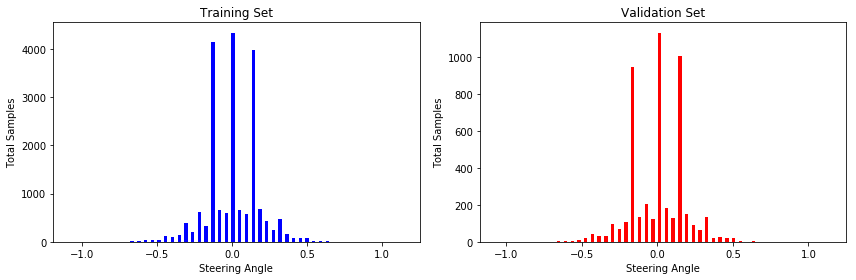

In [6]:
def show_steering(y_train, y_valid):
    bin_size = 50
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax0, ax1 = axes.flatten()

    ax0.hist(y_train, bins=bin_size, rwidth=0.5, label='train', color='blue')
    ax0.set_title('Training Set')
    ax0.set_xlabel('Steering Angle')
    ax0.set_ylabel('Total Samples')

    ax1.hist(y_valid, bins=bin_size, rwidth=0.5, label='valid', color='red')
    ax1.set_title('Validation Set')
    ax1.set_xlabel('Steering Angle')
    ax1.set_ylabel('Total Samples')
    
    fig.tight_layout()
    plt.show()   
    fig.savefig('graph_sup/raw_dist.png',bbox_inches = 'tight')
show_steering(y_train, y_valid)

***
* From above distribution plots. The data skewed toward (0, -.25, .25) steering angles. This will inject 'straight bias' to the model so that the model will not perform well on turning events (especially in Track 2). So, the data balance need to be applied before training

* Dynamic data balance function used below. The higher abs steering angle, the higher chance keeped in training set. 
***

In [7]:
def balance_sample(X, y):
    bin_size = 50
    sample_per_bin = 1.5*round(len(y)/bin_size)
    hist, bins = np.histogram(y, bin_size)
    keep_prob = []
    for i in range(bin_size):
        if hist[i] < sample_per_bin:
            keep_prob.append(1.0)
        else:
            keep_prob.append(1.0/(hist[i]/sample_per_bin))
    drop_list = []
    for i in range(len(y)):
        for j in range(bin_size):
            if (y[i] > bins[j] and y[i] <= bins[j+1]):
                if np.random.rand() > keep_prob[j]:
                    drop_list.append(i)
    X_new = np.delete(X, drop_list, axis=0)
    y_new = np.delete(y, drop_list)
    return  X_new,y_new

In [8]:
# balanced train/test split
X_train_b, y_train_b = balance_sample(X_train, y_train)
X_valid_b, y_valid_b = balance_sample(X_valid, y_valid)
print ('Training samples: {}\nValid samples: {}'.format(len(X_train_b),len(X_valid_b)))

Training samples: 8364
Valid samples: 2101


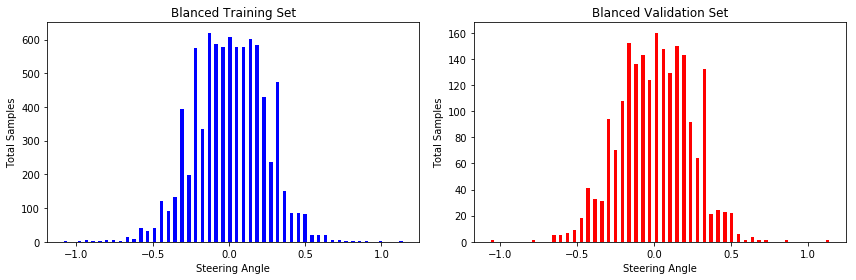

In [9]:
# Check and show the train, validation data steering feature
def show_steering(y_train, y_valid, bla_y_train, bal_y_valid):
    bin_size = 50
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax2, ax3 = axes.flatten()
    
    ax2.hist(bla_y_train, bins=bin_size, rwidth=0.5, label='train', color='blue')
    ax2.set_title('Blanced Training Set')
    ax2.set_xlabel('Steering Angle')
    ax2.set_ylabel('Total Samples')

    ax3.hist(bal_y_valid, bins=bin_size, rwidth=0.5, label='valid', color='red')
    ax3.set_title('Blanced Validation Set')
    ax3.set_xlabel('Steering Angle')
    ax3.set_ylabel('Total Samples')
    fig.tight_layout()
    plt.show()   
    fig.savefig('graph_sup/balanced_dist.png',bbox_inches = 'tight')
show_steering(y_train, y_valid, y_train_b, y_valid_b)

***
* The training/valid data set looks more normal distributed after data balance.
***

### Step 2 Image jittering

***
For purpose of recovering. The jittered image are generated for training.

2.1 Image flip

2.2 Image translation

2.3 Image brightness 

2.4 Image shadow 

2.5 Random jitter training image
  
***

In [9]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [10]:
# Apply shifts on both x and y axis to simulate behaviors when car is in different position on the road.
def img_random_translate(image, steering_angle):
    h, w, ch = image.shape
    transx = 100 * (np.random.rand() - 0.5)
    transy = 40 * (np.random.rand() - 0.5)
    trans_m = np.float32([[1, 0, transx], [0, 1, transy]])
    image = cv2.warpAffine(image, trans_m, (w, h))
    new_angle = steering_angle + transx/100*2*.2
    return image, new_angle

In [11]:
def img_random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    d_bias = 0.25
    bright_rate = d_bias + np.random.uniform()
    hsv[:,:,2] =  hsv[:,:,2] * bright_rate
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img

In [12]:
def img_random_shadow(image):
    h, w = image.shape[:2]
    x1, y1 = w * np.random.rand(), 0
    x2, y2 = w * np.random.rand(), h
    xm, ym = np.mgrid[0:h, 0:w]
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(0.3, 0.8)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    img = cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)
    return img

In [13]:
def random_augument(image, steering_angle):
    img = mpimg.imread(image)
    steering = steering_angle
    if np.random.randint(3) == 0 or 1:
        img, steering = img_random_flip(img, steering)
    if np.random.randint(3) == 0 or 1:
        img, steering = img_random_translate(img, steering)
    if np.random.randint(3) == 0 or 1:
        img = img_random_shadow(img)
    if np.random.randint(3) == 0 or 1:
        img = img_random_brightness(img)
    return img,steering

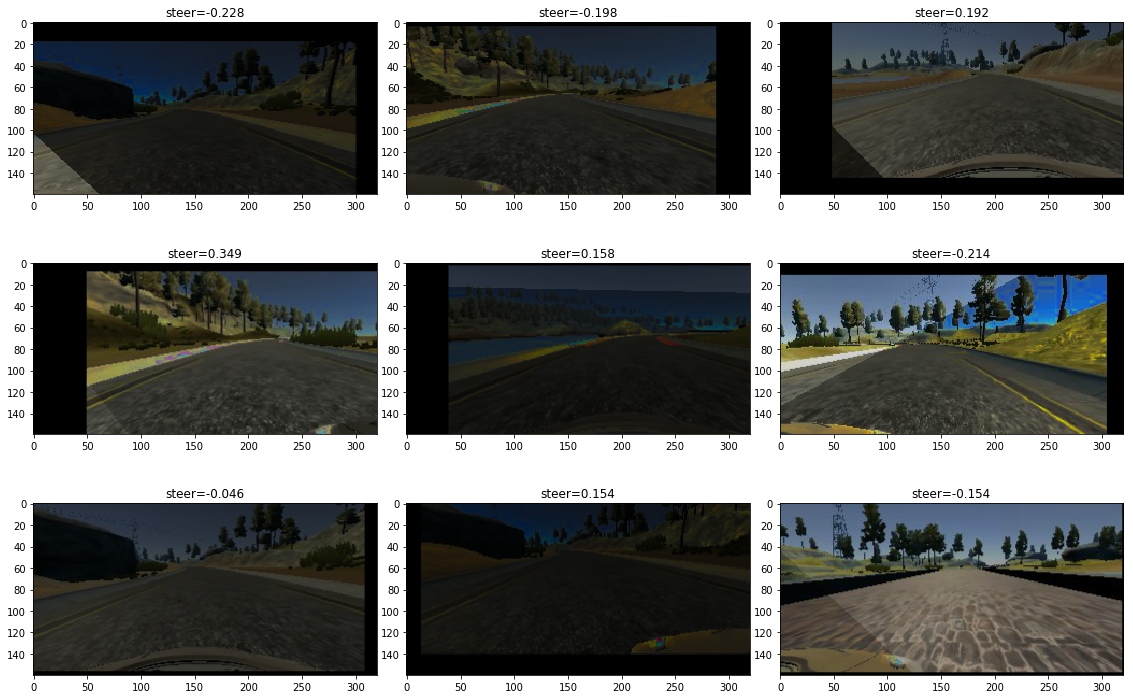

In [14]:
# sample image for visualization jittering effects
plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(3,3,hspace=0.4,wspace=0.01) 
for i in range(9):
    sample_idx = np.random.randint(len(image_paths))
    random_imgs = image_paths[sample_idx]
    random_steer = steerings[sample_idx]
    img,steering = random_augument(random_imgs, random_steer)
    ax = plt.subplot(gs[i])
    ax.set_title("steer={0:.3f}".format(steering))
    plt.imshow(img)
plt.savefig('graph_sup/augumentation_sample.png',bbox_inches = 'tight')

### Step 3 - Image preprocess before feed in model (crop, resize)
3.1 Crop area: [60:-25,:,:]

3.2 resize: (66, 200, 3) Nvidia Paper used


In [15]:
img_height, img_width, channel = 66, 200, 3
def img_preprocess(img, img_height, img_width):
    new_img = img[60:-25,:,:]
    new_img = cv2.GaussianBlur(new_img, (3,3), 0)
    new_img = cv2.resize(new_img, (img_width, img_height), interpolation = cv2.INTER_AREA)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2YUV)
    return new_img

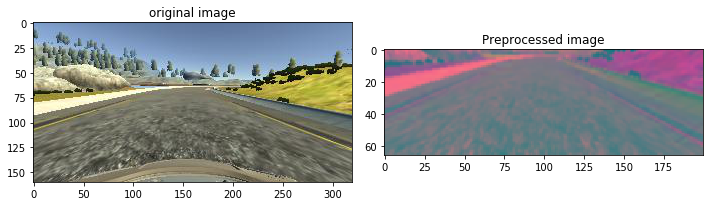

In [16]:
random_imgs = image_paths[np.random.randint(len(image_paths))]
s_img = mpimg.imread(random_imgs)
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 2,hspace=0,wspace=0.1) 
ax0=plt.subplot(gs[0])
ax0.set_title('original image')
plt.imshow(s_img)
ax1=plt.subplot(gs[1])
ax1.set_title('Preprocessed image')
plt.imshow(img_preprocess(s_img,img_height,img_width))
plt.savefig('graph_sup/preprocessed_image.png',bbox_inches = 'tight')

### Step 3 - Data Generator and Model build

In [17]:
def batch_generator(image_paths, steerings, batch_size, istraining):
    img_height,img_width,ch = 66, 200, 3
    image_paths, steerings = shuffle(image_paths, steerings)

    while True:
        for offset in range(0,len(steerings),batch_size):
            batch_samples = image_paths[offset:offset+batch_size]
            batch_steerings = steerings[offset:offset+batch_size]
            images_gen = []
            steerings_gen = []
            for i in range(len(batch_samples)):
                image = batch_samples[i]
                steering_angle = batch_steerings[i]
                #if istraining and np.random.rand() < 0.6:
                image, steering_angle = random_augument(image, steering_angle)
                #else:
                #image = mpimg.imread(image, steering_angle)
                images_gen.append(img_preprocess(image,img_height,img_width))
                steerings_gen.append(steering_angle)
            yield (np.asarray(images_gen), np.asarray(steerings_gen))
            image_paths, steerings = shuffle(image_paths, steerings)

In [18]:
def model_structure():
    model = Sequential()
    model.add(Lambda(lambda x: (x/127.5)-0.5, input_shape=(66, 200,3)))
    model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(96, (3, 3), activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    print(model.summary())
    return model

In [19]:
def train_model(model, X_train, X_valid, y_train, y_valid, learn_rate, batch_size, number_epoch):
    model_file = 'model.h5'
    early_stop = EarlyStopping(patience=5, verbose=1)
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
    model.compile(loss='mse', optimizer=Adam(lr=learn_rate))
    history = model.fit_generator(batch_generator(X_train, y_train, batch_size, True),
                                  steps_per_epoch=round(len(X_train)/batch_size), 
                                  epochs=number_epoch,
                                  validation_data=batch_generator(X_valid, y_valid, batch_size, False),
                                  validation_steps=round(len(X_valid)/batch_size),
                                  callbacks=[checkpoint],
                                  verbose=1)
    model.save(model_file)
    return history

In [22]:
import time
start = time.time()
res = train_model(model_structure(),X_train_b, X_valid_b, y_train_b, y_valid_b, 1e-4, 64, 30)
end = time.time()
print('Done! Time Used: {}s'.format(end-start))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_9 (Batch (None, 31, 98, 24)        96        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 47, 36)        144       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
batch_normalization_11 (Batc (None, 5, 22, 48)         192       
__________

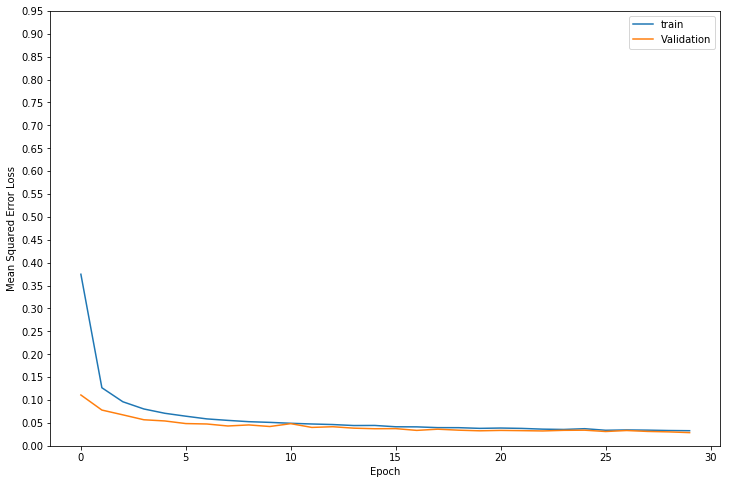

In [29]:
fig = plt.figure(figsize=(12,8))
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.yticks(np.arange(0, 1, step=0.05))
plt.xticks(np.arange(0, 35, step=5))
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'], loc='upper right')
plt.show()
fig.savefig('graph_sup/val_loss.png')